# Accessing the [oceanwatch](http://oceanwatch.pifsc.noaa.gov/) data with Python

In [1]:
%matplotlib inline

In [35]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import requests

### run the following to download the data using the generated URL (you need to copy it from your browser):

In [5]:
url = 'http://oceanwatch.pifsc.noaa.gov/erddap/griddap/OceanWatch_aqua_chla_monthly.nc?chla[(2015-05-01T00:00:00Z):1:(2016-05-01T00:00:00Z)][(17):1:(30)][(195):1:(210)]'

In [6]:
r = requests.get(url)

In [7]:
with open('./chl.nc', 'wb') as f:
    f.write(r.content)

### open file

In [8]:
dset= xr.open_dataset('./chl.nc')

In [9]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 261, longitude: 301, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
  * latitude   (latitude) float64 17.0 17.05 17.1 17.15 17.2 17.25 17.3 ...
  * longitude  (longitude) float64 195.0 195.1 195.1 195.2 195.2 195.2 195.3 ...
Data variables:
    chla       (time, latitude, longitude) float64 0.05137 0.05258 0.0549 ...
Attributes:
    acknowledgements:           NASA Goddard Space Flight Center
    cdm_data_type:              Grid
    comment:                    AQUA MODIS Ocean Color data product
    contributor_name:           NOAA OceanWatch - Central Pacific
    contributor_url:            http://oceanwatch.pifsc.noaa.gov
    Conventions:                COARDS, CF-1.6, ACDD-1.3
    creator_email:              NESDIS.Data.Access@noaa.gov
    creator_name:               NOAA/NESDIS/OceanWatch - Central Pacific
    creator_url:                http://www.nesdis.noaa.gov/
    date_created:        

### examine which variables are included in the dataset


In [16]:
dset.var()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    chla     float64 0.0005661

### extract chla 

In [94]:
chl = dset['chla']

### examine structure of chl

In [96]:
chl.dims

('time', 'latitude', 'longitude')

### examine the dates

In [98]:
dset.time

<xarray.DataArray 'time' (time: 13)>
array(['2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-05-01 2015-06-01 2015-07-01 ...
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [  1.43043840e+09   1.46206080e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00

### get lon and lat

In [20]:
lon = dset['longitude']

In [21]:
lat = dset['latitude']

## Working with the data

### Creating a map of Chl a for May 2015 (our first time step)


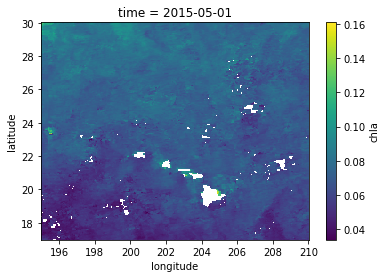

In [25]:
dset.sel(time='2015-05-01')['chla'].plot()

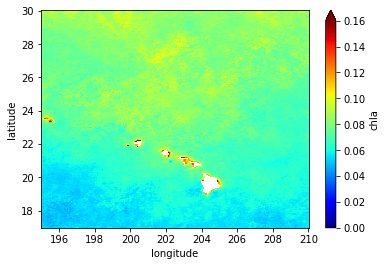

In [29]:
dset['chla'].median('time').plot(vmin=0, vmax=0.16, cmap=plt.get_cmap('jet'))

In [31]:
chla = dset['chla'].median('time')

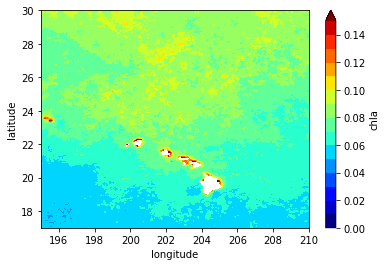

In [40]:
chla.plot.contourf(levels = np.arange(0,0.16,0.01), cmap=plt.cm.jet)

In [67]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy import feature as cfeature

In [68]:
proj = ccrs.PlateCarree()

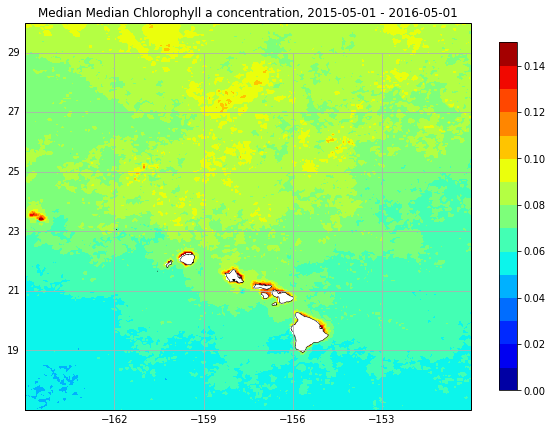

In [90]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

ax.add_feature(cfeature.GSHHSFeature(scale='full', lw=0.5, facecolor='w'))

im = ax.contourf(lon, lat, chla, levels = np.arange(0,0.16,0.01), cmap=plt.cm.jet)

plt.colorbar(im, ax=ax, shrink=0.8)

gl = ax.gridlines(xlocs=lon[::60]-360, ylocs=lat[::40], draw_labels=True)

gl.xlabels_top = gl.ylabels_right = False

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

ax.set_xlabel('longitude')

ax.set_ylabel('latitude')

ax.set_title('Median Median Chlorophyll a concentration, {:%Y-%m-%d} - {:%Y-%m-%d}'.format(dset.time.to_index()[0], dset.time.to_index()[-1]))

In [86]:
dset.time.to_index()[0]

Timestamp('2015-05-01 00:00:00')